In [1]:
# if open from google colab, run this command
from google.colab import drive
drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Github/sales-prediction-gru/ipynb
%cd /content/drive/Shareddrives/BUAT\ DIEGO/Data-retail-2015-2022-keluar/

Mounted at /content/drive
/content/drive/Shareddrives/BUAT DIEGO/Data-retail-2015-2022-keluar


In [2]:
import os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model

import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Loading data

In [20]:
# df2015 = pd.read_csv('./data-2015-renew.csv')
df2016 = pd.read_csv('./data-2016-renew.csv', parse_dates=['tgl'])
df2017 = pd.read_csv('./data-2017-renew.csv', parse_dates=['tgl'])
df2018 = pd.read_csv('./data-2018-renew.csv', parse_dates=['tgl'])
df2019 = pd.read_csv('./data-2019-renew.csv', parse_dates=['tgl'])
# df2020 = pd.read_csv('./data-2020-renew.csv')
# df2021 = pd.read_csv('./data-2021-renew.csv')
# df2022 = pd.read_csv('./data-2022-renew.csv')

In [21]:
df2016 = df2016.drop(['notxn', 'nonota', 'namabarang', 'hargajual', 'hargabeli', 'diskon', 'hargaafterdiskon', 'subtotal', 'kodeop', 'isbkp', 'kodecustomer', 'iddistributor', 'idpromo', 'iddivisi', 'jenis', 'kategori', 'kodedepartemen', 'departemen', 'namaop', 'kodedivisibarang', 'divisibarang'], axis=1)
df2017 = df2017.drop(['notxn', 'nonota', 'namabarang', 'hargajual', 'hargabeli', 'diskon', 'hargaafterdiskon', 'subtotal', 'kodeop', 'isbkp', 'kodecustomer', 'iddistributor', 'idpromo', 'iddivisi', 'jenis', 'kategori', 'kodedepartemen', 'departemen', 'namaop', 'kodedivisibarang', 'divisibarang'], axis=1)
df2018 = df2018.drop(['notxn', 'nonota', 'namabarang', 'hargajual', 'hargabeli', 'diskon', 'hargaafterdiskon', 'subtotal', 'kodeop', 'isbkp', 'kodecustomer', 'iddistributor', 'idpromo', 'iddivisi', 'jenis', 'kategori', 'kodedepartemen', 'departemen', 'namaop', 'kodedivisibarang', 'divisibarang'], axis=1)
df2019 = df2019.drop(['notxn', 'nonota', 'namabarang', 'hargajual', 'hargabeli', 'diskon', 'hargaafterdiskon', 'subtotal', 'kodeop', 'isbkp', 'kodecustomer', 'iddistributor', 'idpromo', 'iddivisi', 'jenis', 'kategori', 'kodedepartemen', 'departemen', 'namaop', 'kodedivisibarang', 'divisibarang'], axis=1)

In [22]:
df = pd.concat([df2016, df2017, df2018])

In [23]:
df['bulantahun'] = df['tgl'].apply(lambda x: x.strftime('%Y-%m')).astype(str)
df['month_yr'] = df['tgl'].apply(lambda x: x.strftime('%m-%y')).astype(str)

In [24]:
df['month_yr'] = df['month_yr'].map({'01-16':0,'02-16':1,'03-16':2,'04-16':3,'05-16':4,'06-16':5,'07-16':6,'08-16':7,'09-16':8,'10-16':9,'11-16':10,'12-16':11,
                                          '01-17':12,'02-17':13,'03-17':14,'04-17':15,'05-17':16,'06-17':17,'07-17':18,'08-17':19,'09-17':20,'10-17':21,'11-17':22,'12-17':23,
                                          '01-18':24,'02-18':25,'03-18':26,'04-18':27,'05-18':28,'06-18':29,'07-18':30,'08-18':31,'09-18':32,'10-18':33,'11-18':34,'12-18':35})

In [25]:
print(f"Min date from data set: {df['tgl'].min().date()}")
print(f"Max date from data set: {df['tgl'].max().date()}")

Min date from data set: 2016-01-01
Max date from data set: 2018-12-31


#EDA

In [26]:
df.head()

,tgl,satuan,qty,barcode,kodejenis,kodekategori,bulantahun,month_yr
0,2016-10-28 12:09:33.220,PCS,4.00,8991038110354,10507,105.00,2016-10,9
1,2016-01-02 15:51:33.187,PCS,1.00,4902430400664,10304,103.00,2016-01,0
2,2016-07-22 18:48:08.593,PCS,1.00,8992772198011,10506,105.00,2016-07,6
3,2016-06-24 11:46:13.417,PCS,1.00,8992933621112,20102,201.00,2016-06,5
4,2016-11-06 13:57:40.160,PCS,2.00,3014260842956,10307,103.00,2016-11,10


In [27]:
# overall sales trend
df_trend = df.groupby('bulantahun').sum()['qty'].reset_index()

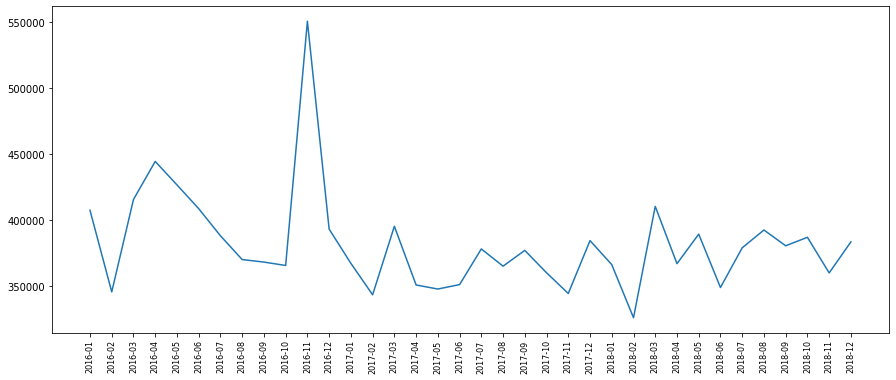

In [28]:
plt.figure(figsize=(15,6))
plt.plot(df_trend['bulantahun'], df_trend['qty'])
plt.xticks(rotation='vertical', size=8)
plt.show()

In [29]:
df.nunique()

tgl             7593763
satuan               61
qty                3591
barcode           30351
kodejenis           171
kodekategori         23
bulantahun           36
month_yr             36
dtype: int64

In [30]:
# top 10 most selling poducts
prod_sales = pd.DataFrame(df.groupby('barcode').sum()['qty'])

In [31]:
prod_sales = prod_sales.sort_values('qty', ascending=False)

In [32]:
prod_sales[:10]

,qty
barcode,
56102,488765.32
56103,364115.75
089686010947,141272.00
56104,125267.96
56101,119737.00
8998866200301,96883.00
13662,87301.00
8992696404441,68255.00
8998866200325,52009.00


In [33]:
daily_sales = df.groupby("bulantahun", as_index=False)['qty'].sum()
# store_daily_sales = df.groupby(['store', 'bulantahun'], as_index=False)['sales'].sum()
item_daily_sales = df.groupby(['barcode', 'bulantahun'], as_index=False)['qty'].sum()

In [34]:
# dail sales

daily_sales_sc = go.Scatter(x=daily_sales['bulantahun'], y=daily_sales['qty'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='bulantahun'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

In [35]:
# daily sales by item
item_daily_sales_sc = []
for item in item_daily_sales['barcode'].unique():
    current_item_daily_sales = item_daily_sales[(item_daily_sales['barcode'] == item)]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['bulantahun'], y=current_item_daily_sales['qty'], name=('Item %s' % item)))

layout = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=item_daily_sales_sc, layout=layout)
iplot(fig)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# a